In [49]:
exec(open("notebooks\Crosswalk-area\init_notebook.py", "r").read())
%load_ext autoreload
%autoreload 2

current working dirC:\Users\ryanc\Documents\GitHub\CM194\carla-jaywalker-experiments
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from shapely.geometry import Polygon, Point, LineString
from shapely import affinity
import matplotlib.pyplot as plt
import math
import random
import seaborn as sb
# from agents.pedestrians.destination import CrosswalkGeometry

In [2]:
'''Functions that might be useful'''

# Find m and b
def fx(point1, point2):
    # m = (y1 - y2) / (x1 - x2)
    if (point1.x - point2.x) != 0:
        m = (point1.y - point2.y) / (point1.x - point2.x)
    else:
        m = None
    print("m =", m)
    
    # b = y - mx
    b = point1.y - (m * point1.x)
    print("b =", b)
    
    return m, b

# Find only m
def slope(point1, point2):
    # m = (y1 - y2) / (x1 - x2)
    if (point1.x - point2.x) != 0:
        m = (point1.y - point2.y) / (point1.x - point2.x)
    else:
        m = None
    print("m =", m)
    return m

# Find only b
def y_intercept(point, m):
    # b = y - mx
    b = point.y - (m * point.x)
    print("b =", b)
    return b

# Find distance from point to line
# Equations to find point to line:
# +=d = (mx3 - y3 + C) / ((m^2 + 1)) ^ 0.5
def distance(point, m, b):
    x = point.x
    y = point.y
    d = (m * x - y + b) / ((m ** 2 + 1)) ** 0.5
    return d

# Find a random side given a polygon
def randSide(polygon):
    x,y = polygon.exterior.xy
    n = len(x) - 1
    index = random.randint(-1, n-1)
    pointA = Point((x[index], y[index]))
    pointB = Point((x[index+1], y[index+1]))
    return LineString([pointA, pointB])

In [3]:
# Generate areaPolygon given a start point and a goalLine
def genPolyArea(start, end, goalLine):

    # Get start point coordinates
    start_x, start_y = start.coords[0][0], start.coords[0][1]
    # Extract goalLine information
    goalLine_x1, goalLine_y1 = goalLine.coords[0][0], goalLine.coords[0][1] 
    goalLine_x2, goalLine_y2 = goalLine.coords[1][0], goalLine.coords[1][1]

    # Generate base as perpendicular to the verticle line
    verticleLine = LineString([start, end])
    baseRight = affinity.rotate(verticleLine, -90, origin=start)
    baseLeft = affinity.rotate(verticleLine, 90, origin=start)
    
    # Bottom left point
    botLeft = baseLeft.interpolate(0.5, normalized=False)
    botLeft_x = botLeft.coords[0][0]
    botLeft_y = botLeft.coords[0][1]

    # Bottom right point
    botRight = baseRight.interpolate(0.5, normalized=False)
    botRight_x = botRight.coords[0][0]
    botRight_y = botRight.coords[0][1]

    # Top left point
    topLeft_x = goalLine_x1
    topLeft_y = goalLine_y1
    topLeft = Point((topLeft_x, topLeft_y))
    # Top right point
    topRight_x = goalLine_x2
    topRight_y = goalLine_y2
    topRight = Point((topRight_x, topRight_y))
    # Mid left point
    midLeft_x = min(botLeft_x, topLeft_x) + (max(botLeft_x, topLeft_x) - min(botLeft_x, topLeft_x))/1.5
    midLeft_y = (topLeft_y - botLeft_y)/2
    midLeft = Point((midLeft_x, midLeft_y))
    # Mid right point
    midRight_x = min(botRight_x, topRight_x) + (max(botRight_x, topRight_x) - min(botRight_x, topRight_x))/3
    midRight_y = (topRight_y - botRight_y) / 2
    midRight = Point((midRight_x, midRight_y))

    # Build areaPolygon
    areaPolygon = Polygon([botLeft, midLeft, topLeft, topRight, midRight, botRight])
    return areaPolygon

In [4]:
# Generate n intermediate points given start and end point.
def pointsOnLine(start, end, n):
    pointsOL = [start]
    line = LineString([start, end])
    gap = 1 / (n + 1)
    d = gap
    for i in range(n):
        point = line.interpolate(d, normalized=True)
        d = d + gap
        pointsOL.append(point)
    pointsOL.append(end)
    return pointsOL

In [5]:
# Rotate a single point +-90 degrees given an origin.
def pointRotate(point, origin, degree=90):
    rotated_point = affinity.rotate(point, degree, origin=origin)
    return rotated_point

In [6]:
# Find a random point on a straight line between two points.
def pointBetween(start, end, d):
    line = LineString([start, end])
    point = line.interpolate(d, normalized=True)
    return point

In [7]:
def closestEnd(point, goalLine):
    d = goalLine.project(point)
    end = goalLine.interpolate(d)
    return end

In [8]:
# Find the angle in radian between two given lines
# Formula:
# atan2(vec2.y-vec1.y, vec2.x-vec1.x)
# atan((m1 - m2) / (1 + m1*m2)) 

def degreeFromX(line):
    # Extract points from line1 and line2
    x = line.coords[1][0] - line.coords[0][0]
    y = line.coords[1][1] - line.coords[0][1]

    # Find theta using formula
    theta = math.atan2(y, x)

    return theta

In [9]:
# Add angle restraints:
# Absolute_max - max angle between new line and verticle line from new point
# Delta_max - max angle between new line and previous line

def shiftedPoints(start, end, crosswalk, goalLine, maxAbsDegree, maxDeltaDegree, nInterPoints=3, maxInterPointsDistance=1.5):
    new_points = [start]
    pointsOL = pointsOnLine(start, end, nInterPoints)
    for i in range(len(pointsOL) - 2):
        start = pointsOL[1]
        end = pointsOL[2]
        done = False
        while not done:
            chance = random.choice([0, 1])
            pointToRot = pointBetween(start, end, d=random.uniform(0, 1)) # modify d if needed
            if chance == 0:
                new_point = pointRotate(pointToRot, start, degree=90)
                
            else:
                new_point = pointRotate(pointToRot, start, degree=-90)
            # Check constraints
            if crosswalk.contains(new_point):
                segment = LineString([start, end])
                new_line = LineString([new_points[-1], new_point])
                prev_line = None
                if i > 0:
                    prev_line = LineString([new_points[-2], new_points[-1]])
                if new_line.length <= segment.length*maxInterPointsDistance:
                    if prev_line == None:
                        done = True
                    else:
                        # Find verticle line
                        vert_start = new_points[-1]
                        vert_end = closestEnd(vert_start, goalLine)
                        vert_line = LineString([vert_start, vert_end])
                        # Calculate the angle between the new line and the verticle line
                        a_theta = degreeFromX(vert_line) - degreeFromX(new_line)
                        # Calculate the angle between the new line and the extended previous line
                        d_theta = degreeFromX(prev_line) - degreeFromX(new_line)

                        if maxAbsDegree*(-1) <= a_theta <= maxAbsDegree and maxDeltaDegree*(-1) <= d_theta <= maxDeltaDegree:
                            done = True
        
        new_points.append(new_point)
        new_start = new_point
        extend_end = new_line.interpolate(10, normalized=True)
        new_end = closestEnd(extend_end, goalLine)
        
        pointsOL = pointsOnLine(new_start, new_end, nInterPoints-(i+1))

    # final rotate to find end point is different
    final_start = new_end
    final_end = new_start
    done = False
    while not done:
        pointToRot = pointBetween(final_start, final_end, d=random.uniform(0, 1))
        chance = random.random()
        if chance > 0.5:
            final_rot = pointRotate(pointToRot, final_start, degree=90)
        else:
            final_rot = pointRotate(pointToRot, final_start, degree=-90)
        
        segment = LineString([final_start, final_end])
        new_line = LineString([new_points[-1], final_rot])
        prev_line = LineString([new_points[-2], new_points[-1]])
        if new_line.length <= segment.length*maxInterPointsDistance:
            # Find verticle line
            vert_start = new_points[-1]
            vert_end = closestEnd(vert_start, goalLine)
            vert_line = LineString([vert_start, vert_end])
            # Calculate the angle between the new line and the verticle line
            a_theta = degreeFromX(vert_line) - degreeFromX(new_line)
            # Calculate the angle between the new line and the extended previous line
            d_theta = degreeFromX(prev_line) - degreeFromX(new_line)
            if maxAbsDegree*(-1) <= a_theta <= maxAbsDegree and maxDeltaDegree*(-1) <= d_theta <= maxDeltaDegree:
                done = True    
    
    if goalLine.contains(final_rot) == False:
        final_rot = closestEnd(final_rot, goalLine)
    new_points.append(final_rot)
    
    return new_points

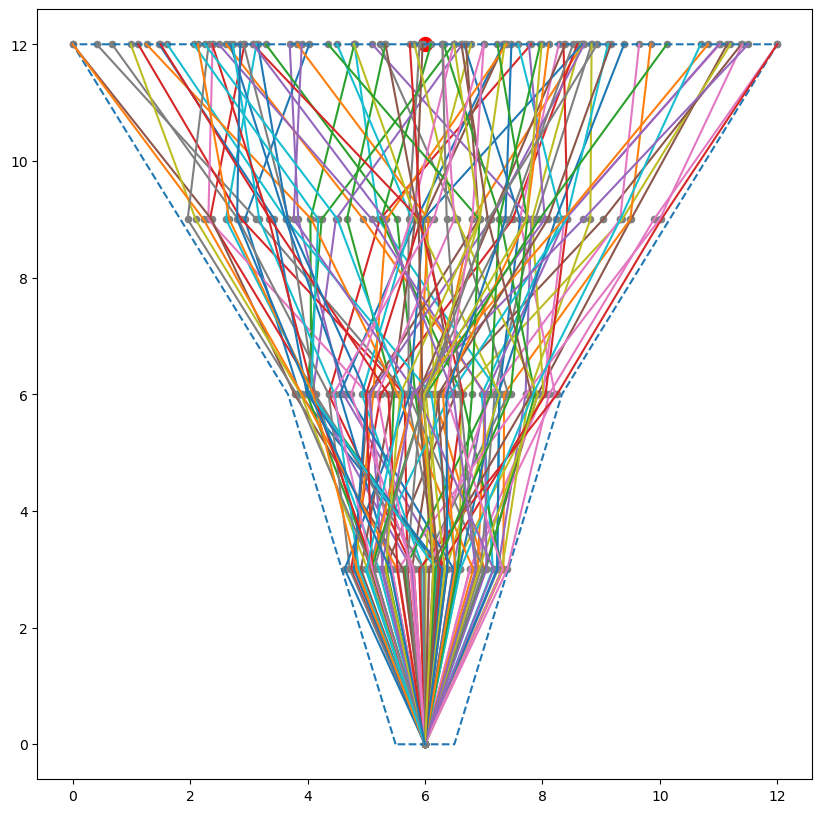

In [15]:
# Case 1: control
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
start = Point(6, 0)
end = Point(6, 12)
p = genPolyArea(start, end, goalLine)

data = {'x': [], 'y': []}

plt.rcParams["figure.figsize"] = (10,10)
x,y = p.exterior.xy
plt.plot(x,y, '--')
plt.scatter(end.x, end.y, s=100, color='red')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    new_points = shiftedPoints(start, end, p, goalLine, maxAbsDegree, maxDeltaDegree)

    for j in range(len(new_points)):
        line_x.append(new_points[j].x)
        line_y.append(new_points[j].y)

        if new_points[j] != start:
            data['x'].append(new_points[j].x)
            data['y'].append(new_points[j].y)

        plt.scatter(new_points[j].x, new_points[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

# Visualizing data
sb.jointplot(data=data, x='x', y='y')

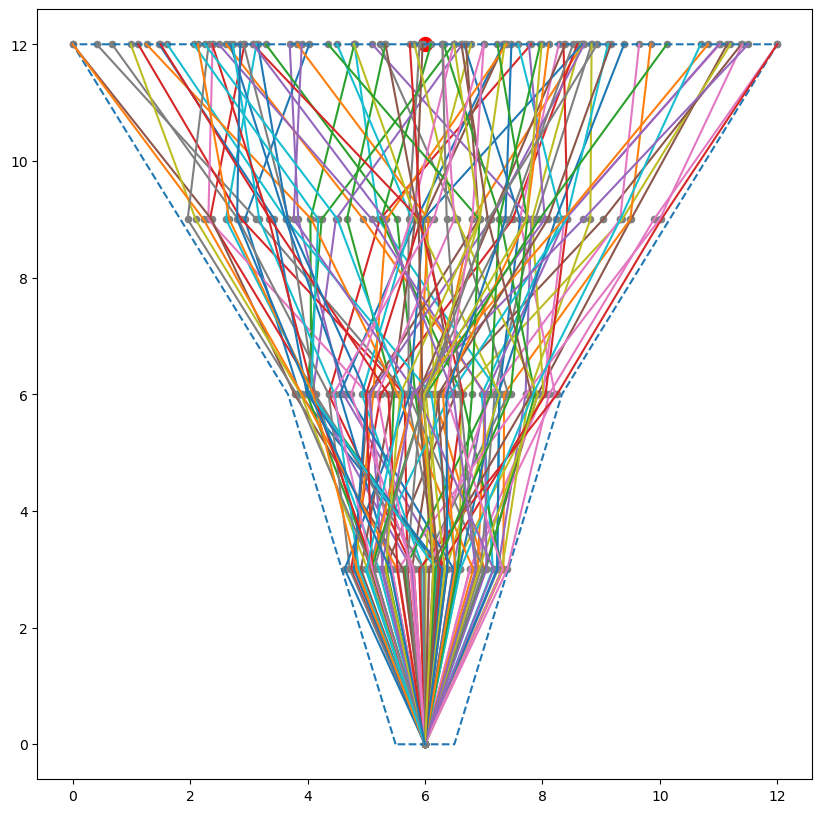

In [15]:
# Case 1: control
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
start = Point(6, 0)
end = Point(6, 12)
p = genPolyArea(start, end, goalLine)

data = {'x': [], 'y': []}

plt.rcParams["figure.figsize"] = (10,10)
x,y = p.exterior.xy
plt.plot(x,y, '--')
plt.scatter(end.x, end.y, s=100, color='red')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(100):
    line_x = []
    line_y = []
    new_points = shiftedPoints(start, end, p, goalLine, maxAbsDegree, maxDeltaDegree)

    for j in range(len(new_points)):
        line_x.append(new_points[j].x)
        line_y.append(new_points[j].y)

        if new_points[j] != start:
            data['x'].append(new_points[j].x)
            data['y'].append(new_points[j].y)

        plt.scatter(new_points[j].x, new_points[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

# Visualizing data
sb.jointplot(data=data, x='x', y='y')